# Odds and Addends

In [1]:
include("utils.jl"); using .Utils
checkpkgs("Plots", "DataFrames", "Statistics")
using Plots, DataFrames, Statistics

## Odds

In [2]:
odds(p) = p / (1-p)

odds (generic function with 1 method)

In [3]:
odds(0.75)

3.0

In [4]:
odds(0.1)

0.11111111111111112

In [5]:
odds(0.9)

9.000000000000002

In [6]:
prob(o) = o / (o+1)

prob (generic function with 1 method)

In [7]:
prob(3/2)

0.6

In [8]:
prob2(yes, no) = yes / (yes + no)

prob2 (generic function with 1 method)

In [9]:
prob2(3, 2)

0.6

## Bayes's Rule

In [10]:
prior_odds = 1
likelihood_ratio = (3/4) / (1/2)
post_odds = prior_odds * likelihood_ratio
post_odds

1.5

In [11]:
post_prob = prob(post_odds)
post_prob

0.6

In [12]:
likelihood_ratio = (1/4) / (1/2)
post_odds *= likelihood_ratio
post_odds

0.75

In [13]:
post_prob = prob(post_odds)
post_prob

0.42857142857142855

## Oliver's Blood

In [14]:
like1 = 0.01
like2 = 2 * 0.6 * 0.01

likelihood_ratio = like1 / like2
likelihood_ratio

0.8333333333333334

In [15]:
post_odds = 1 * like1 / like2
prob(post_odds)

0.45454545454545453

In [16]:
# Ex 6.1
post_odds = odds(0.9) * like1 / like2
prob(post_odds)

0.8823529411764706

In [17]:
post_odds = odds(0.1) * like1 / like2
prob(post_odds)

0.0847457627118644

## Addends

In [18]:
include("empiricaldist.jl"); using .EmpiricalDist
function make_die(sides)
    outcomes = 1:sides
    die = Pmf(1/sides, outcomes)
    return die
end

make_die (generic function with 1 method)

In [19]:
die = make_die(6);

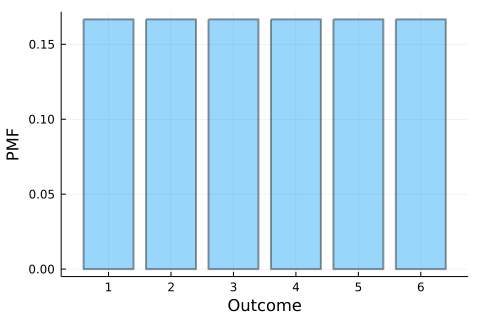

In [20]:
bar(die, alpha=0.4)
xlabel!("Outcome")
ylabel!("PMF")

In [21]:
"""Compute the distribution of a sum."""
function add_dist(pmf1, pmf2)
    res = Pmf()
    for (q1, p1) in pairs(pmf1)
        for (q2, p2) in pairs(pmf2)
            q = q1 + q2
            p = p1 * p2
            res[q] = res(q) + p
        end
    end
    return res
end

add_dist

In [22]:
twice = add_dist(die, die);

In [23]:
function decorate_dice!(title="")
    xlabel!("Outcome")
    ylabel!("PMF")
    title!(title)
end
decorate_dice!(;title="") = decorate_dice!(title)

decorate_dice! (generic function with 2 methods)

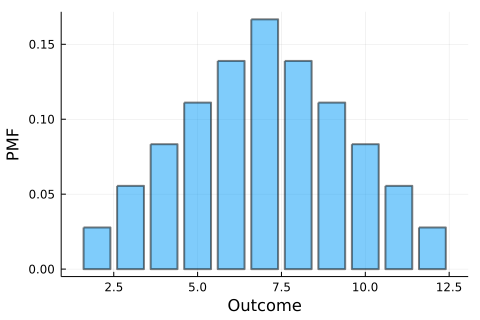

In [24]:
twice = adddist(die, die) # from EmpiricalDist
bar(twice, alpha=0.5)
decorate_dice!()

In [25]:
"""Compute Pmf of the sum of values from seq."""
function add_dist_seq(seq)
    total = seq[1]
    for other in seq[2:end]
        total = add_dist(total, other)
    end
    return total
end

add_dist_seq

In [26]:
dice = repeat([die], 3);

In [27]:
thrice = add_dist_seq(dice);

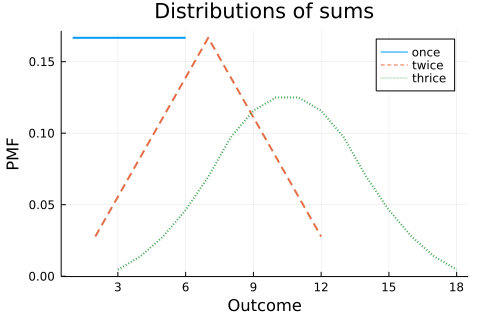

In [28]:
plot(die, label="once")
plot!(twice, label="twice", style=:dash)
plot!(thrice, label="thrice", style=:dot)
xticks!([0,3,6,9,12,15,18])
decorate_dice!(title="Distributions of sums")

## Gluten Sensitivity

## The Forward Problem

In [29]:
n = 35
num_sensitive = 10
num_insensitive = n - num_sensitive;

In [30]:
dist_sensitive = makebinomial(num_sensitive, 0.95);
dist_insensitive = makebinomial(num_insensitive, 0.40);

In [31]:
dist_total = adddist(dist_sensitive, dist_insensitive);

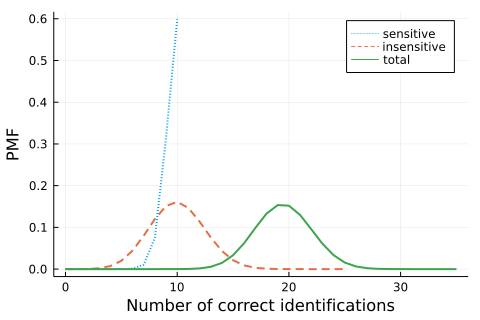

In [32]:
plot(dist_sensitive, label="sensitive", style=:dot)
plot!(dist_insensitive, label="insensitive", style=:dash)
plot!(dist_total, label="total")

xlabel!("Number of correct identifications")
ylabel!("PMF")

## The Inverse Problem

In [33]:
table = DataFrame()
for num_sensitive in 0:n
    num_insensitive = n - num_sensitive
    dist_sensitive = makebinomial(num_sensitive, 0.95)
    dist_insensitive = makebinomial(num_insensitive, 0.4)
    dist_total = adddist(dist_sensitive, dist_insensitive)
    insert!(table, dist_total; colname=num_sensitive)
end

In [34]:
first(table, 3)

,index,0,1,2,3,4,5
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,0,1.71907e-8,1.43256e-9,1.1938e-10,9.94833e-12,8.29027e-13,6.90856e-14
2,1,4.01117e-7,5.969e-8,7.16279e-9,7.79286e-10,8.01393e-11,7.94484e-12
3,2,4.54599e-6,9.7414e-7,1.70912e-7,2.50643e-8,3.26913e-9,3.94018e-10


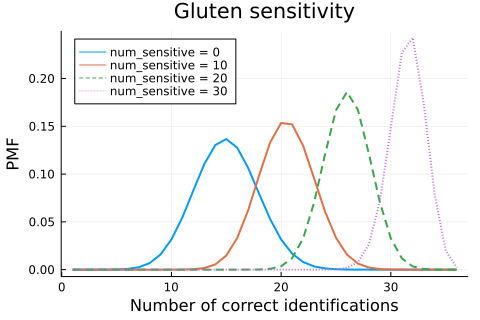

In [35]:
plot(table[!, "0"], label="num_sensitive = 0", legend=:topleft)
plot!(table[!, "10"], label="num_sensitive = 10")
plot!(table[!, "20"], label="num_sensitive = 20", style=:dash)
plot!(table[!, "30"], label="num_sensitive = 30", style=:dot)
xlabel!("Number of correct identifications")
ylabel!("PMF")
title!("Gluten sensitivity")

In [36]:
function dfrow(df, n)
    # helper to get row with *index* `n` from `df`. Note this is not
    # the same as the `n`-th *row*
    # In addition, we want to drop the `index` column from the result.
    # Not the prettiest sight :(
    row = select(table, Not(:index))[findfirst(==(n), table.index), :]
    return collect(row)
end

likelihood1 = dfrow(table, 12);

In [37]:
hypos = 0:n
prior = Pmf(1, hypos);

In [38]:
posterior1 = prior .* likelihood1
normalize!(posterior1)

0.4754741648615129

In [39]:
likelihood2 = dfrow(table, 20)
posterior2 = prior .* likelihood2
normalize!(posterior2)

1.7818649765887364

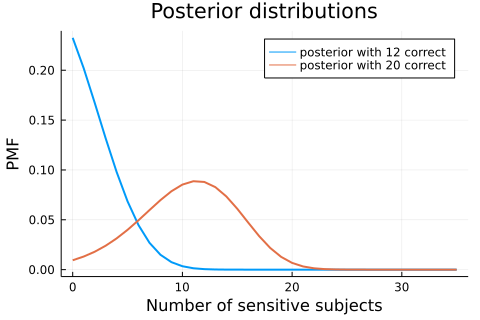

In [40]:
plot(posterior1, label="posterior with 12 correct")
plot!(posterior2, label="posterior with 20 correct")

xlabel!("Number of sensitive subjects")
ylabel!("PMF")
title!("Posterior distributions")

In [41]:
maxprob(posterior1)

0

In [42]:
maxprob(posterior2)

11

## Summary

## Exercises

In [43]:
# 6.2
prior_odds = odds(1/3);

In [44]:
post_odds = prior_odds * 2 * 1.25;

In [45]:
prob(post_odds)

0.5555555555555555

In [46]:
# 6.3
prior_odds = odds(0.1);

In [47]:
post_odds = prior_odds * 2 * 2 * 2;

In [48]:
prob(post_odds)

0.4705882352941177

In [49]:
# 6.4
prior_odds = odds(0.14);

In [50]:
post_odds = prior_odds * 25;

In [51]:
prob(post_odds)

0.8027522935779816

In [52]:
# 6.5
d6 = make_die(6);

In [53]:
hit_points = adddist(d6, d6);

In [54]:
damage = adddist(d6, 3);

In [55]:
typeof(damage)

Pmf{Float64, Int64}

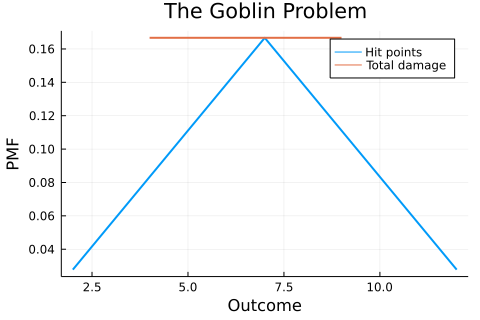

In [56]:
plot(hit_points, label="Hit points")
plot!(damage, label="Total damage")
decorate_dice!("The Goblin Problem")

In [57]:
points_left = subdist(hit_points, damage);

In [58]:
prob_le(points_left, 0)

0.5

In [59]:
# 6.6
hypos = [6, 8, 12]
prior = Pmf(1, hypos);

In [60]:
d4 = make_die(4)
muldist(d4, d4)

┌────┬────────┐
│    │  probs │
├────┼────────┤
│  1 │ 0.0625 │
│  2 │  0.125 │
│  3 │  0.125 │
│  4 │ 0.1875 │
│  6 │  0.125 │
│  8 │  0.125 │
│  9 │ 0.0625 │
│ 12 │  0.125 │
│ 16 │ 0.0625 │
└────┴────────┘


In [61]:
likelihood = []
for sides in hypos
    die = make_die(sides)
    d = muldist(die, die)
    push!(likelihood, d[12])
end

likelihood

3-element Vector{Any}:
 0.1111111111111111
 0.0625
 0.04166666666666667

In [62]:
posterior = prior .* likelihood
normalize!(posterior)
posterior

┌────┬──────────┐
│    │    probs │
├────┼──────────┤
│  6 │ 0.516129 │
│  8 │ 0.290323 │
│ 12 │ 0.193548 │
└────┴──────────┘


In [63]:
# 6.7
die = subdist(make_die(3), 1)
pmfs = Dict()
pmfs["Bellows"] = adddist(repeat([die],3))
pmfs["Zostra"] = adddist(repeat([die],4))
pmfs["Longfellow"] = adddist(repeat([die],5));

In [64]:
pmfs["Zostra"](4)

0.2345679012345679

In [65]:
prod(pmfs["Zostra"]([3,4,5]))

0.00915247412224499

In [66]:
hypos = collect(keys(pmfs))
prior = Pmf(1/3, hypos)
prior

┌────────────┬──────────┐
│            │    probs │
├────────────┼──────────┤
│    Bellows │ 0.333333 │
│ Longfellow │ 0.333333 │
│     Zostra │ 0.333333 │
└────────────┴──────────┘


In [67]:
likelihood = similar(prior) # create a new Pmf with same keys

for hypo in hypos
    likelihood[hypo] = prod(pmfs[hypo]([3,4,5]))
end

likelihood

┌────────────┬────────────┐
│            │      probs │
├────────────┼────────────┤
│    Bellows │ 0.00640146 │
│ Longfellow │ 0.00479827 │
│     Zostra │ 0.00915247 │
└────────────┴────────────┘


In [68]:
posterior = (prior .* likelihood)
normalize!(posterior)
posterior

┌────────────┬──────────┐
│            │    probs │
├────────────┼──────────┤
│    Bellows │ 0.314534 │
│ Longfellow │ 0.235762 │
│     Zostra │ 0.449704 │
└────────────┴──────────┘


In [69]:
# 6.8
n=538

table = DataFrame()
for n_honest in 0:n
    n_dishonest = n - n_honest

    dist_honest = makebinomial(n_honest, 0.5)
    dist_dishonest = makebinomial(n_dishonest, 0.9)

    dist_total = adddist(dist_honest, dist_dishonest)
    insert!(table, dist_total; colname=n_honest)
end
size(table) # including the `index` column

(539, 540)

In [70]:
data = 312
likelihood = dfrow(table, data)
length(likelihood)

539

In [71]:
hypos = 0:n
prior = Pmf(1, hypos)
length(prior)

539

In [72]:
posterior = prior .* likelihood
normalize!(posterior)
mean(posterior)

431.48821145019986

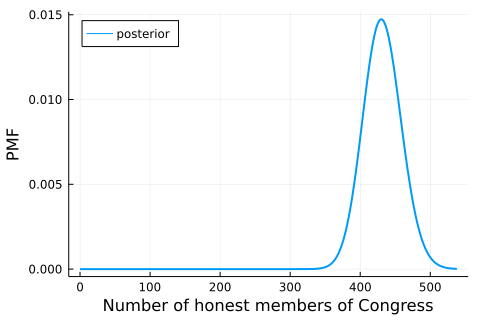

In [73]:
# Solution
plot(posterior, label="posterior", legend=:topleft)
xlabel!("Number of honest members of Congress")
ylabel!("PMF")